In [4]:

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import pyodbc
import urllib
from sqlalchemy import create_engine


In [6]:
df = pd.read_csv("transactions_patterned.csv")
df.columns

# # Define connection parameters
# server = 'statements.database.windows.net'
# database = 'statements'
# username = 'azureuser'
# password = '!Gba!rum0le'
# driver = '{ODBC Driver 17 for SQL Server}'

# params = urllib.parse.quote_plus(
#     f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'
# )
# engine = create_engine(f'mssql+pyodbc:///?odbc_connect={params}')
# df.to_sql('transactions', con=engine, if_exists='append', index=False)
# df = pd.read_sql_table('transactions', con=engine)



Index(['tran_dt', 'sender', 'receiver', 'amount', 'sender_prev_bal'], dtype='object')

In [7]:
def engineer_features(df):
    df_fe = df.copy()
    
    df_fe['tran_dt'] = pd.to_datetime(df_fe['tran_dt'])
    
    df_fe['tran_day'] = df_fe['tran_dt'].dt.day
    df_fe['tran_month'] = df_fe['tran_dt'].dt.month
    df_fe['tran_dayofweek'] = df_fe['tran_dt'].dt.dayofweek
    df_fe['tran_is_weekend'] = df_fe['tran_dayofweek'].isin([5, 6]).astype(int)
    
    df_fe['amount_to_balance_ratio'] = df_fe['amount'] / df_fe['sender_prev_bal']
    df_fe['amount_to_balance_ratio'] = df_fe['amount_to_balance_ratio'].replace([np.inf, -np.inf], 100)
    df_fe['amount_to_balance_ratio'] = df_fe['amount_to_balance_ratio'].fillna(0)
    
    df_fe['amount_exceeds_balance'] = (df_fe['amount'] > df_fe['sender_prev_bal']).astype(int)
    
    sender_stats = df_fe.groupby('sender').agg({
        'amount': ['mean', 'std', 'count', 'max'],
        'sender_prev_bal': ['mean']
    }).reset_index()
    
    sender_stats.columns = ['_'.join(col).strip('_') for col in sender_stats.columns.values]
    
    # Rename columns for clarity
    sender_stats = sender_stats.rename(columns={
        'sender_': 'sender',
        'amount_mean': 'sender_mean_amount',
        'amount_std': 'sender_std_amount',
        'amount_count': 'sender_tx_count',
        'amount_max': 'sender_max_amount',
        'sender_prev_bal_mean': 'sender_mean_balance'
    })
    
    df_fe = pd.merge(df_fe, sender_stats, on='sender', how='left')
    
    df_fe['sender_std_amount'] = df_fe['sender_std_amount'].fillna(0)
    
    df_fe['amount_zscore'] = np.nan
    mask = (df_fe['sender_tx_count'] > 1) & (df_fe['sender_std_amount'] > 0)
    df_fe.loc[mask, 'amount_zscore'] = (
        (df_fe.loc[mask, 'amount'] - df_fe.loc[mask, 'sender_mean_amount']) / 
        df_fe.loc[mask, 'sender_std_amount']
    )
    df_fe['amount_zscore'] = df_fe['amount_zscore'].fillna(0)
    
    receiver_stats = df_fe.groupby('receiver').agg({
        'amount': ['mean', 'count'],
    }).reset_index()
    
    receiver_stats.columns = ['_'.join(col).strip('_') for col in receiver_stats.columns.values]
    
    receiver_stats = receiver_stats.rename(columns={
        'receiver_': 'receiver',
        'amount_mean': 'receiver_mean_amount',
        'amount_count': 'receiver_tx_count'
    })
    
    df_fe = pd.merge(df_fe, receiver_stats, on='receiver', how='left')
    
    if df_fe['receiver_tx_count'].max() > 0:
        df_fe['receiver_suspicion_score'] = df_fe['receiver_tx_count'] / df_fe['receiver_tx_count'].max()
    else:
        df_fe['receiver_suspicion_score'] = 0
    
    df_fe.drop('tran_dt', axis=1, inplace=True)
    
    return df_fe

df_processed = engineer_features(df)

print("\nFeature-engineered data:")
print(df_processed.head())



Feature-engineered data:
       sender    receiver   amount  sender_prev_bal  tran_day  tran_month  \
0  2301805351  1532644469   147.66          1295.20        20          10   
1  3703962220  2349736332    89.77          9479.55         4           6   
2  1529943053  3465910025   133.80          6677.19         7           2   
3  2555233206  7707731783  1251.02          4546.55        13           6   
4  1761232323  4532052055    55.01          6418.36         3           8   

   tran_dayofweek  tran_is_weekend  amount_to_balance_ratio  \
0               4                0                 0.114006   
1               6                1                 0.009470   
2               1                0                 0.020038   
3               1                0                 0.275158   
4               3                0                 0.008571   

   amount_exceeds_balance  sender_mean_amount  sender_std_amount  \
0                       0          224.650714         210.587837

In [8]:
features = [
    'amount', 'sender_prev_bal', 'tran_day', 'tran_month', 'tran_dayofweek',
    'tran_is_weekend', 'amount_to_balance_ratio', 'amount_exceeds_balance'
]

sender_receiver_features = [
    'sender_mean_amount', 'sender_std_amount', 'sender_tx_count', 
    'sender_max_amount', 'sender_mean_balance', 'amount_zscore',
    'receiver_mean_amount', 'receiver_tx_count', 'receiver_suspicion_score'
]

for feature in sender_receiver_features:
    if feature in df_processed.columns:
        features.append(feature)

print("\nFeatures used for anomaly detection:")
print(features)
X = df_processed[features].copy()
X.fillna(0, inplace=True)
X.columns = [str(col) for col in X.columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features used for anomaly detection:
['amount', 'sender_prev_bal', 'tran_day', 'tran_month', 'tran_dayofweek', 'tran_is_weekend', 'amount_to_balance_ratio', 'amount_exceeds_balance', 'sender_mean_amount', 'sender_std_amount', 'sender_tx_count', 'sender_max_amount', 'sender_mean_balance', 'amount_zscore', 'receiver_mean_amount', 'receiver_tx_count', 'receiver_suspicion_score']


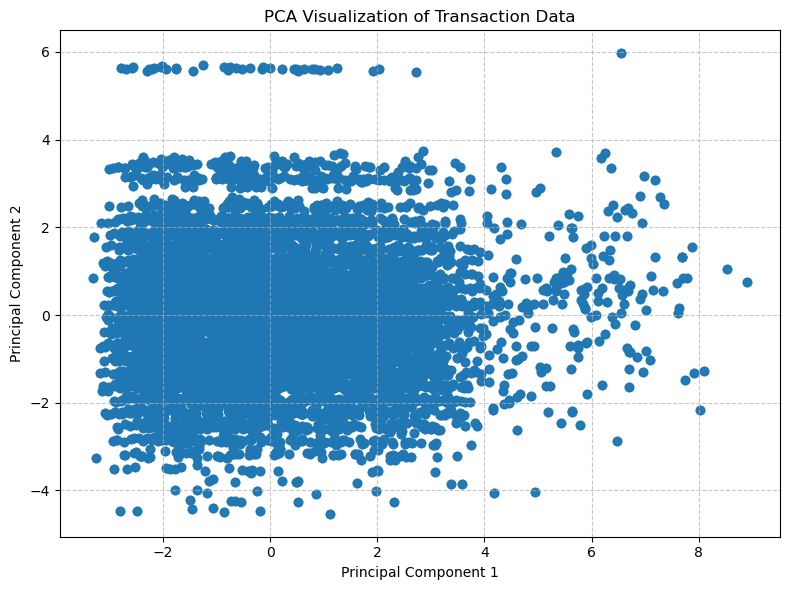

In [19]:
# --- PCA Block (Optional) ---
try:
    if len(X) >= 3:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

        df_processed['pca1'] = X_pca[:, 0]
        df_processed['pca2'] = X_pca[:, 1]

        plt.figure(figsize=(8, 6))
        plt.scatter(df_processed['pca1'], df_processed['pca2'], alpha=0.7)
        plt.title('PCA Visualization of Transaction Data')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
except Exception as e:
    print(f"PCA visualization failed: {e}")



In [20]:
# --- Isolation Forest Block (Always Executes) ---
print("\n--- Applying Isolation Forest for Anomaly Detection ---")
contamination = min(0.2, 1/len(X))
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=contamination,  
    random_state=42,
    bootstrap=True 
)
iso_forest_pred = iso_forest.fit_predict(X_scaled)
df_processed['iso_forest_anomaly'] = (iso_forest_pred == -1).astype(int)
iso_forest_scores = iso_forest.score_samples(X_scaled)
df_processed['iso_forest_score'] = iso_forest_scores
df_processed['iso_forest_anomaly_score'] = 1 - (iso_forest_scores - iso_forest_scores.min()) / (
    (iso_forest_scores.max() - iso_forest_scores.min()) or 1
)

print(f"Isolation Forest detected {df_processed['iso_forest_anomaly'].sum()} anomalies out of {len(df_processed)} transactions")



--- Applying Isolation Forest for Anomaly Detection ---
Isolation Forest detected 0 anomalies out of 30000 transactions


In [21]:
results_df = df.copy()
results_df['anomaly_score'] = df_processed['iso_forest_anomaly_score']
results_df['is_anomaly'] = df_processed['iso_forest_anomaly']


In [22]:
conditions = [
    (df_processed['iso_forest_anomaly_score'] < 0.5),
    (df_processed['iso_forest_anomaly_score'] >= 0.5) & (df_processed['iso_forest_anomaly_score'] < 0.8),
    (df_processed['iso_forest_anomaly_score'] >= 0.8)
]
choices = ['low', 'medium', 'high']
results_df['risk_level'] = np.select(conditions, choices, default='unknown')

print(results_df)



          id    tran_dt      sender    receiver   amount  sender_prev_bal  \
0          1 2023-10-20  2301805351  1532644469   147.66          1295.20   
1          2 2023-06-04  3703962220  2349736332    89.77          9479.55   
2          3 2023-02-07  1529943053  3465910025   133.80          6677.19   
3          4 2023-06-13  2555233206  7707731783  1251.02          4546.55   
4          5 2023-08-03  1761232323  4532052055    55.01          6418.36   
...      ...        ...         ...         ...      ...              ...   
29995  29996 2023-06-26  9971126046  6527612750   291.54          9796.93   
29996  29997 2023-02-18  6581131506  6704460197   400.83          2905.65   
29997  29998 2023-04-15  9898976418  3605787210    68.75          4468.60   
29998  29999 2023-08-17  6954377166  8141239801   126.89          1990.84   
29999  30000 2023-05-22  8893138539  4644663335   499.27          9640.94   

       anomaly_score  is_anomaly risk_level  
0           0.372170         

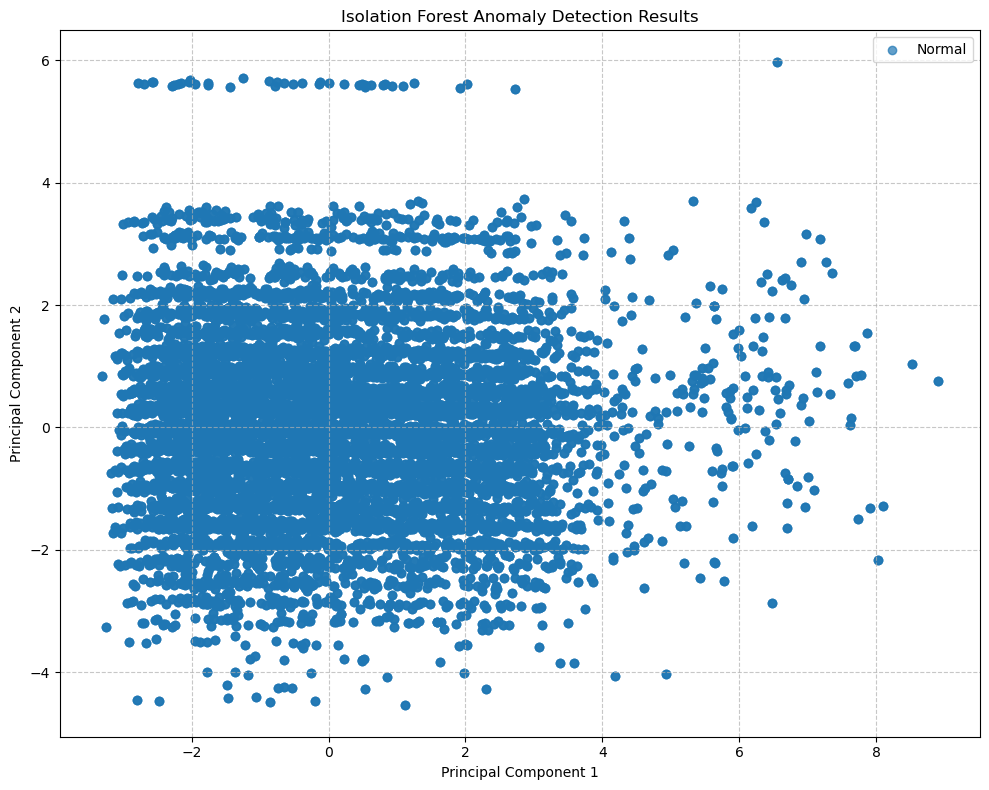

In [23]:
if 'pca1' in df_processed.columns and 'pca2' in df_processed.columns:
    plt.figure(figsize=(10, 8))
    plt.scatter(df_processed[df_processed['iso_forest_anomaly'] == 0]['pca1'], 
                df_processed[df_processed['iso_forest_anomaly'] == 0]['pca2'], 
                alpha=0.7, label='Normal')

    if df_processed['iso_forest_anomaly'].sum() > 0:
        plt.scatter(df_processed[df_processed['iso_forest_anomaly'] == 1]['pca1'], 
                    df_processed[df_processed['iso_forest_anomaly'] == 1]['pca2'], 
                    color='red', alpha=0.7, marker='X', s=100, label='Anomaly')

    plt.title('Isolation Forest Anomaly Detection Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
else:
    print("Skipping final plot: PCA features not available.")


In [13]:
# def detect_fraud(transaction_data, model, scaler, features, threshold=0.8):
#     if not isinstance(transaction_data, pd.DataFrame):
#         if isinstance(transaction_data, dict):
#             transaction_data = pd.DataFrame([transaction_data])
#         else:
#             raise ValueError("transaction_data must be a DataFrame or dictionary")
    
#     processed_data = engineer_features(transaction_data)
    
#     available_features = [f for f in features if f in processed_data.columns]
#     X = processed_data[available_features].copy()
#     X.fillna(0, inplace=True)
    
#     for feature in features:
#         if feature not in X.columns:
#             X[feature] = 0
            
#     X = X[features]
    
#     X_scaled = scaler.transform(X)
    
#     anomaly_scores = model.score_samples(X_scaled)
    
#     min_score = anomaly_scores.min()
#     max_score = anomaly_scores.max()
#     if max_score > min_score:
#         anomaly_probs = 1 - (anomaly_scores - min_score) / (max_score - min_score)
#     else:
#         anomaly_probs = np.zeros_like(anomaly_scores)
    
#     results = transaction_data.copy()
#     results['fraud_score'] = anomaly_probs
#     results['is_fraud_flagged'] = (anomaly_probs > threshold).astype(int)
    
#     conditions = [
#         (anomaly_probs < 0.5),
#         (anomaly_probs >= 0.5) & (anomaly_probs < 0.8),
#         (anomaly_probs >= 0.8)
#     ]
#     choices = ['low', 'medium', 'high']
#     results['risk_level'] = np.select(conditions, choices, default='unknown')
    
#     return results


In [23]:
def fraud_detection_pipeline(new_transaction_data):

    required_fields = ['tran_dt', 'sender', 'receiver', 'amount', 'sender_prev_bal']
    for field in required_fields:
        if field not in new_transaction_data.columns:
            raise ValueError(f"Missing required field: {field}")
    
    results = detect_fraud(new_transaction_data, iso_forest, scaler, features)
    
    return results[['tran_dt', 'sender', 'receiver', 'amount', 'sender_prev_bal', 
                    'fraud_score', 'is_fraud_flagged', 'risk_level']]



In [24]:
# def train_fraud_detection_model(transaction_file_path):
#     df = pd.read_csv(transaction_file_path)
    
#     df_processed = engineer_features(df)
    
#     features = [
#         'amount', 'sender_prev_bal', 'tran_day', 'tran_month', 'tran_dayofweek',
#         'tran_is_weekend', 'amount_to_balance_ratio', 'amount_exceeds_balance',
#         'sender_mean_amount', 'sender_std_amount', 'sender_tx_count', 
#         'sender_max_amount', 'sender_mean_balance', 'amount_zscore',
#         'receiver_mean_amount', 'receiver_tx_count', 'receiver_suspicion_score'
#     ]
    
#     features = [f for f in features if f in df_processed.columns]
    
#     X = df_processed[features].fillna(0)
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     contamination = min(0.05, 10/len(X))  
#     model = IsolationForest(
#         n_estimators=100,
#         contamination=contamination,
#         random_state=42,
#         bootstrap=True
#     )
#     model.fit(X_scaled)
    
#     return model, scaler, features


# model, scaler, features = train_fraud_detection_model('transactions_patterned.csv')


# new_transactions = pd.read_csv('transactions_patterned.csv')
# results = detect_fraud(new_transactions, model, scaler, features)
 

In [22]:
print(results)
print(results[results['is_fraud_flagged'] == 1]) 

         tran_dt      sender    receiver   amount  sender_prev_bal  \
0     2023-10-20  2301805351  1532644469   147.66          1295.20   
1     2023-06-04  3703962220  2349736332    89.77          9479.55   
2     2023-02-07  1529943053  3465910025   133.80          6677.19   
3     2023-06-13  2555233206  7707731783  1251.02          4546.55   
4     2023-08-03  1761232323  4532052055    55.01          6418.36   
...          ...         ...         ...      ...              ...   
9995  2023-06-26  9971126046  6527612750   291.54          9796.93   
9996  2023-02-18  6581131506  6704460197   400.83          2905.65   
9997  2023-04-15  9898976418  3605787210    68.75          4468.60   
9998  2023-08-17  6954377166  8141239801   126.89          1990.84   
9999  2023-05-22  8893138539  4644663335   499.27          9640.94   

      fraud_score  is_fraud_flagged risk_level  
0        0.398273                 0        low  
1        0.378970                 0        low  
2        0.2